In [2]:
import pandas as pd
from tqdm import tqdm
from functools import cache
import matplotlib.pyplot as plt
import seaborn as sns
from utils import canonicalize_smiles
import random
import numpy as np

tqdm.pandas()

In [3]:
DATA_DIR = "../data/"
FIGURE_DIR = "../figures/"

In [4]:
sns.set_style(style="ticks")
sns.set_context(context="talk")

# Load dataset

In [5]:
df = pd.read_csv(
    f"{DATA_DIR}/processed/enpkg_data_with_threshold.tsv.gz",
    compression="gzip",
    sep="\t",
)

# Convert smiles to molecules and scaffolds

In [6]:
# Canonicalize SMILES
df["smiles"] = df["smiles"].apply(canonicalize_smiles)

[00:12:39] SMILES Parse Error: syntax error while parsing: unknown
[00:12:39] SMILES Parse Error: Failed parsing SMILES 'unknown' for input: 'unknown'
[00:12:39] Explicit valence for atom # 0 B, 5, is greater than permitted


# Cumulative counts

In [7]:
# Group by plant_id and count the number of ms2mol_smiles
compounds_in_plant = df.groupby("wikidata_species_id").count().reset_index()

In [8]:
# make a dictinoary from the plant_id to a set of ms2mol_smiles
plant_structures = df.groupby("wikidata_species_id")["inchikey"].apply(set).to_dict()

In [9]:
compounds_in_plant.set_index("wikidata_species_id", inplace=True)

## Shuffle ordering of plants and plot cumulative number of plants

In [10]:
DEFAULT_COLOR_PALETTE = [
    "#F10A84",
    "#80BDE9",
    "#6A8D3E",
    "#BCD20B",
    "#5C7CFC",
    "#6942D9",
    "#F6E547",
    "#FA5F0D",
    "#E93848",
]

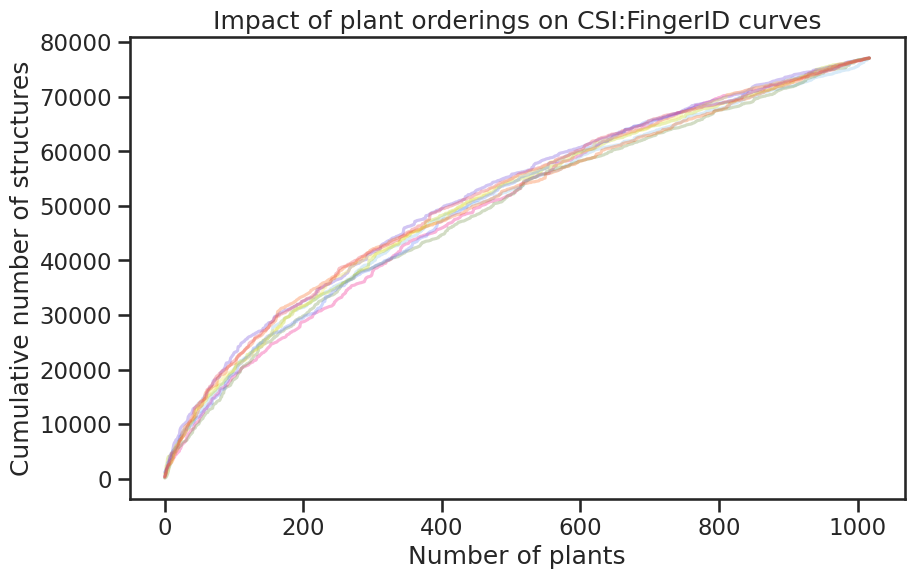

In [11]:
plt.figure(figsize=(10, 6))

for i in range(9):
    counts = []
    counts_scaffold = []

    current_set = set()
    current_set_scaffold = set()

    wiki_species_id_order = list(df.wikidata_species_id.unique())
    random.shuffle(wiki_species_id_order)

    for plant in wiki_species_id_order:
        # gets the set of smiles for the plant
        smiles = plant_structures[plant]

        # updates the current set with the smiles for the plant
        current_set.update(smiles)
        # stores the length of the current set
        counts.append(len(current_set))

    # compounds_in_plant.set_index("wikidata_species_id", inplace=True)
    compounds_in_plant = compounds_in_plant.reindex(wiki_species_id_order)

    compounds_in_plant.loc[wiki_species_id_order, "cumulative_structures"] = counts
    compounds_in_plant["num_new"] = compounds_in_plant["cumulative_structures"].diff()

    plt.plot(
        np.arange(len(compounds_in_plant.index)),
        compounds_in_plant["cumulative_structures"],
        alpha=0.3,
        color=DEFAULT_COLOR_PALETTE[i],
    )
plt.ylabel("Cumulative number of structures")
plt.xlabel("Number of plants")
plt.title("Impact of plant orderings on CSI:FingerID curves")
plt.savefig(f"{FIGURE_DIR}/data_curve_random_orderings.png")
plt.show()